#### Just to test if model month-over-month change would make a difference

In [2]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from itertools import product # to expand month-shop-item combo

import pickle

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [3]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

In [4]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int16`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64" or df[c].dtype == 'int32']
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

### Read in Data

In [4]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
train.shape

(2935849, 6)

In [5]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


#### Check what is in other data

In [6]:
items0 = pd.read_csv(r'../data/items.csv')
# shops0 = pd.read_csv(r'../data/shops.csv')
# item_cat0 = pd.read_csv(r'../data/item_categories.csv')
items0 = downcast_dtypes(items0)
items0[:3]# ok contains name of the item/cat/shop; ABBYY FineReader??

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
train[(train.shop_id==25)&(train.item_id==2552)]  
# looks like return. looks like negative rows should be removed
# Or make a "returned?" feature

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [8]:
(train['item_cnt_day']==0).sum()

0

In [9]:
train2 = downcast_dtypes(train[train.item_cnt_day>0])
# train2 = train[(train.item_cnt_day>0) & train.shop_id.isin(test.shop_id.unique())]

print(train2.shape)

train2['date2'] = pd.to_datetime(train2['date'],format='%d.%m.%Y')
train2.drop(labels='date',axis=1,inplace=True)

# print(train2.shop_id.nunique())
# pickle.dump(train2,open(r'../data2/train_42shops.pkl','wb'))
del train

(2928493, 6)


### Expand the month/shop/item grid

In [10]:
shops_in_tr = train2.shop_id.unique()
items_in_tr = train2.item_id.unique()
months_in_tr =train2.date_block_num.unique()
print(len(shops_in_tr),len(items_in_tr),len(months_in_tr))

grid = np.array(list(product(*[shops_in_tr,items_in_tr,months_in_tr])),dtype='int32')

grid = pd.DataFrame(grid,columns=['shop_id','item_id','date_block_num'],dtype='int32')
grid[:3]

60 21804 34


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,22154,1
2,59,22154,2


In [11]:
del shops_in_tr
del items_in_tr
del months_in_tr

### Aggregate sale by month
#### Aggregate on the original data

In [12]:
train2 = pd.merge(train2, items0[['item_id','item_category_id']],how='left')
train2[:3]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date2,item_category_id
0,0,59,22154,999.000000,1.0,2013-01-02,37
1,0,25,2552,899.000000,1.0,2013-01-03,58
2,0,25,2554,1709.050049,1.0,2013-01-06,58


In [13]:
# monthly sales by shop-item
train2.sort_values(by=['date_block_num','shop_id','item_id','date2'],inplace=True)
temp = train2.groupby(['date_block_num','shop_id','item_id'],as_index=False)\
    .agg({'item_cnt_day':{'shop_item_cnt':'sum'}})

temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all = pd.merge(grid, temp, how='left',on=['date_block_num','shop_id','item_id']).fillna(0)

In [14]:
monthly_sales_all[:3]

,shop_id,item_id,date_block_num,shop_item_cnt
0,59,22154,0,1.0
1,59,22154,1,0.0
2,59,22154,2,0.0


In [15]:
del grid

#### Append block 34

In [16]:
test_block = monthly_sales_all.loc[monthly_sales_all.date_block_num==33,['shop_id','item_id','date_block_num']]
test_block.loc[:,'date_block_num'] += 1
print(test_block.date_block_num.unique())
test_block[:3]

[34]


,shop_id,item_id,date_block_num
33,59,22154,34
67,59,2552,34
101,59,2554,34


In [17]:
monthly_sales_all = pd.concat([monthly_sales_all,test_block],ignore_index=True).fillna(0)

In [18]:
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(45788400, 4)


,date_block_num,item_id,shop_id,shop_item_cnt
0,0,22154,59,1.0
1,1,22154,59,0.0
2,2,22154,59,0.0


In [19]:
monthly_sales_all[-5:]

,date_block_num,item_id,shop_id,shop_item_cnt
45788395,34,8428,36,0.0
45788396,34,7903,36,0.0
45788397,34,7610,36,0.0
45788398,34,7635,36,0.0
45788399,34,7640,36,0.0


In [20]:
del test_block

In [21]:
gc.collect()

113

#### Visualize sales trend (and diff trend)

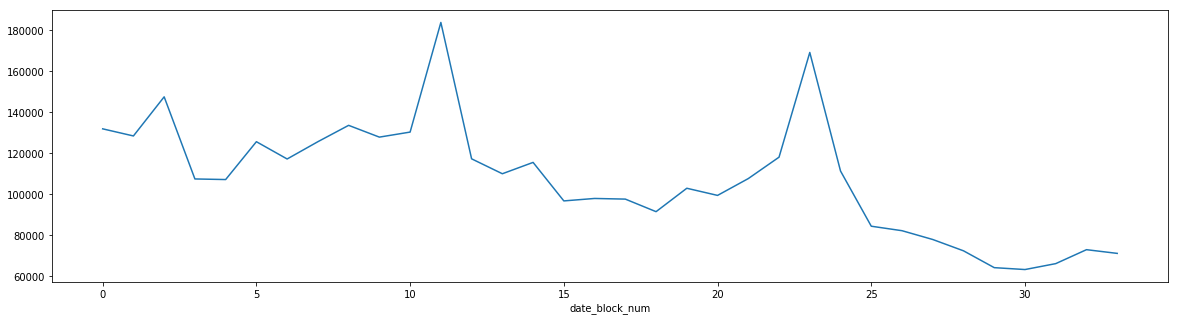

In [22]:
# Clear seasonality - spike in Dec; March
# Also a clear downward sloping trend
plt.figure(figsize=(20,5))
monthly_sales_all[monthly_sales_all.date_block_num<34].groupby(['date_block_num'])['shop_item_cnt'].sum().plot() 

In [23]:
monthly_sales_all.sort_values(by=['shop_id','item_id','date_block_num'],inplace=True)
monthly_sales_all['shop_item_cnt_lag1']=monthly_sales_all.groupby(['shop_id','item_id'])['shop_item_cnt'].shift(1)

In [24]:
monthly_sales_all['diff'] = monthly_sales_all['shop_item_cnt'] - monthly_sales_all['shop_item_cnt_lag1']

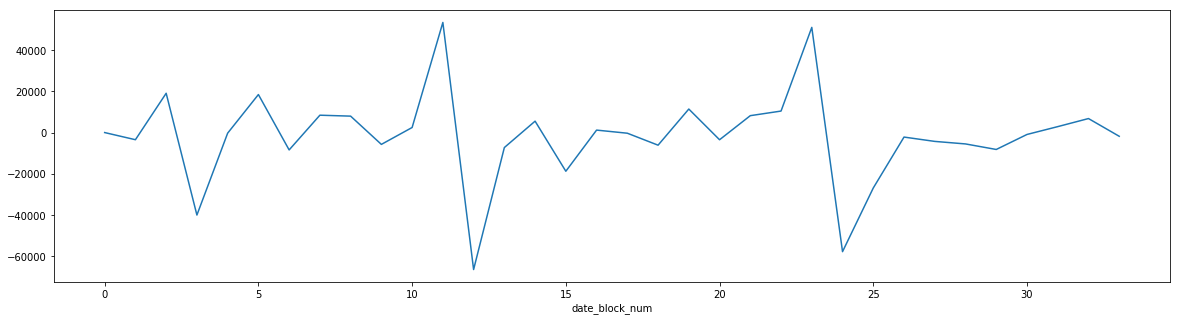

In [25]:
# Also a clear downward sloping trend
plt.figure(figsize=(20,5))
monthly_sales_all[monthly_sales_all.date_block_num<34].groupby(['date_block_num'])['diff'].sum().plot() 

In [26]:
monthly_sales_all[monthly_sales_all.date_block_num==34]['diff'].describe() # QC should <=0

count    1.308240e+06
mean    -5.441203e-02
std      2.282540e+00
min     -2.253000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: diff, dtype: float64

In [27]:
print(monthly_sales_all[monthly_sales_all['diff'].isnull()].date_block_num.unique())  # QC
monthly_sales_all = monthly_sales_all[monthly_sales_all['diff'].notnull()] # Remove date_block_num 0 where no diff is available

[0]


#### Aggregated Diff by Shop, Cat, Item

In [28]:
# monthly sales by shop
temp = monthly_sales_all.groupby(['date_block_num','shop_id'],as_index=False).agg({'diff':{'shop_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','shop_id']).fillna(0)

# monthly sales by item
temp = monthly_sales_all.groupby(['date_block_num','item_id'],as_index=False).agg({'diff':{'item_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_id']).fillna(0)

# monthly sales by cat
# first, get item_category_id of each item on the LHS
monthly_sales_all = pd.merge(monthly_sales_all,items0[['item_id','item_category_id']],how='left',on='item_id')

temp = monthly_sales_all.groupby(['date_block_num','item_category_id'],as_index=False).agg({'diff':{'cat_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id']).fillna(0)

# # downcast types to save memory
monthly_sales_all=downcast_dtypes(monthly_sales_all)
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 10)


,date_block_num,item_id,shop_id,shop_item_cnt,shop_item_cnt_lag1,diff,shop_cnt,item_cnt,item_category_id,cat_cnt
0,1,0,0,0.0,0.0,0.0,549.0,0.0,40,-1851.0
1,2,0,0,0.0,0.0,0.0,-6127.0,0.0,40,4630.0
2,3,0,0,0.0,0.0,0.0,0.0,0.0,40,-8748.0


In [29]:
del train2
del temp

In [30]:
monthly_sales_all[['date_block_num','shop_id']] = monthly_sales_all[['date_block_num','shop_id']].astype(np.int8)

In [43]:
monthly_sales_all.dtypes

date_block_num         int8
item_id               int16
shop_id                int8
diff                float32
shop_cnt            float32
item_cnt            float32
item_category_id      int16
cat_cnt             float32
dtype: object

### Start building features

#### Set up time-based features

<strong>Since we have lag features, we are just going to build the features on entire monthly_sales data w/o spliting monthly_sales and X_val. 
    
However, make sure we do feature selection only on the monthly_sales portion (where date_block_num < hold_out_month) </strong>

In [32]:
temp = monthly_sales_all[['shop_id','item_id','date_block_num','shop_item_cnt','shop_item_cnt_lag1']]
monthly_sales_all.drop(labels=['shop_item_cnt','shop_item_cnt_lag1'],axis=1,inplace=True)

In [36]:
%%time
temp.to_hdf(r'../data2/temp.h5','monthly_sales_all')

Wall time: 3min 3s


In [37]:
del temp

In [46]:
index_cols = ['shop_id','item_id','item_category_id','date_block_num']
cols_to_rename = list(monthly_sales_all.columns.difference(index_cols)) # all columns except these four
shift_range = [1,2,3,4,5,12]
cols_to_rename

['cat_cnt', 'diff', 'item_cnt', 'shop_cnt']

In [47]:
gc.collect()

0

In [48]:
for month_shift in tqdm_notebook(shift_range):
    
    """Take the entire data set, add 1 to date_block_num, and rename the columns that we want to create a lag for"""
    
    train_shift = monthly_sales_all[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    monthly_sales_all = pd.merge(monthly_sales_all, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [49]:
gc.collect()

157

In [50]:
monthly_sales_all['month'] = (np.mod(monthly_sales_all.date_block_num,12)+1).astype('int8')

In [51]:
temp = pd.read_hdf(r'../data2/temp.h5','monthly_sales_all')
print(temp.shape)
temp[:3]

(44480160, 5)


,shop_id,item_id,date_block_num,shop_item_cnt,shop_item_cnt_lag1
0,0,0,1,0.0,0.0
1,0,0,2,0.0,0.0
2,0,0,3,0.0,0.0


In [52]:
monthly_sales_all = pd.merge(monthly_sales_all,temp, on=['date_block_num','shop_id','item_id'],how='left')
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 35)


,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,diff_lag_1,...,diff_lag_5,item_cnt_lag_5,shop_cnt_lag_5,cat_cnt_lag_12,diff_lag_12,item_cnt_lag_12,shop_cnt_lag_12,month,shop_item_cnt,shop_item_cnt_lag1
0,1,0,0,0.0,549.0,0.0,40,-1851.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
1,2,0,0,0.0,-6127.0,0.0,40,4630.0,-1851.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0
2,3,0,0,0.0,0.0,0.0,40,-8748.0,4630.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0


In [53]:
%%time
monthly_sales_all.to_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 1min 48s


In [74]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 7.42 s


In [75]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [ ]:
# # List of all lagged features
# fit_cols = [col for col in monthly_sales_all.columns if col[-1] in [str(item) for item in shift_range]] 
# # We will drop these at fitting stage
# to_drop_cols = list(set(list(monthly_sales_all.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
# to_drop_cols

- <strong>One-hot encode month</strong>

In [8]:
enc = OneHotEncoder()

In [9]:
m_onehot = enc.fit_transform(pd.Series(list(range(1,13))).reshape(-1,1)).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

(12, 12)

In [10]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)], dtype='int8')
m_onehot_df

,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,0,0,0,0
6,7,0,0,0,0,0,1,0,0,0,0,0
7,8,0,0,0,0,0,0,1,0,0,0,0
8,9,0,0,0,0,0,0,0,1,0,0,0
9,10,0,0,0,0,0,0,0,0,1,0,0


In [79]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,diff_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,0.0,0.0,40,-6536.0,3162.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,0.0,0.0,40,-3597.0,-6536.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,0.0,0.0,40,2796.0,-3597.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [80]:
monthly_sales_all = downcast_dtypes(monthly_sales_all)
monthly_sales_all.dtypes

date_block_num           int8
item_id                 int16
shop_id                  int8
diff                  float32
shop_cnt              float32
item_cnt              float32
item_category_id        int16
cat_cnt               float32
cat_cnt_lag_1         float32
diff_lag_1            float32
item_cnt_lag_1        float32
shop_cnt_lag_1        float32
cat_cnt_lag_2         float32
diff_lag_2            float32
item_cnt_lag_2        float32
shop_cnt_lag_2        float32
cat_cnt_lag_3         float32
diff_lag_3            float32
item_cnt_lag_3        float32
shop_cnt_lag_3        float32
cat_cnt_lag_4         float32
diff_lag_4            float32
item_cnt_lag_4        float32
shop_cnt_lag_4        float32
cat_cnt_lag_5         float32
diff_lag_5            float32
item_cnt_lag_5        float32
shop_cnt_lag_5        float32
cat_cnt_lag_12        float32
diff_lag_12           float32
item_cnt_lag_12       float32
shop_cnt_lag_12       float32
shop_item_cnt         float32
shop_item_

#### Predict w lag v RF w lag

In [60]:
hold_out_month = 33
val_month = 32

In [50]:
feats = ['diff_lag_1']

In [51]:
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,shop_item_cnt,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,0.0,0.0,0.0,40,-6536.0,3162.0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,0.0,0.0,0.0,40,-3597.0,-6536.0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,0.0,0.0,0.0,40,2796.0,-3597.0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt','shop_item_cnt_lag_1','diff']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt','shop_item_cnt_lag_1','diff']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,diff,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,diff_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
20,0,0,0.0,NaN,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0
42,0,1,0.0,NaN,0.0,0.0,0.0,0.0,-16.0,0.0,...,0,0,0,0,0,0,1,0,0,0
64,0,2,0.0,NaN,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0


#### Benchmark - on val and hold-out

In [54]:
print('Hold out BC (month 33):')
print(rmse_clip(y_true = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt'],y_pred = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Hold out BC (month 33):
14.068433535527497


In [39]:
print('Val BC (month 32)')
print(rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = val.loc[val.shop_item_cnt>0,'diff']))

Val BC (month 32)
18.07412546239703


#### Model

In [61]:
monthly_sales_all.columns

Index(['date_block_num', 'item_id', 'shop_id', 'diff', 'shop_cnt', 'item_cnt',
       'item_category_id', 'cat_cnt', 'cat_cnt_lag_1', 'diff_lag_1',
       'item_cnt_lag_1', 'shop_cnt_lag_1', 'cat_cnt_lag_2', 'diff_lag_2',
       'item_cnt_lag_2', 'shop_cnt_lag_2', 'cat_cnt_lag_3', 'diff_lag_3',
       'item_cnt_lag_3', 'shop_cnt_lag_3', 'cat_cnt_lag_4', 'diff_lag_4',
       'item_cnt_lag_4', 'shop_cnt_lag_4', 'cat_cnt_lag_5', 'diff_lag_5',
       'item_cnt_lag_5', 'shop_cnt_lag_5', 'cat_cnt_lag_12', 'diff_lag_12',
       'item_cnt_lag_12', 'shop_cnt_lag_12', 'shop_item_cnt',
       'shop_item_cnt_lag1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       'm10', 'm11', 'm12'],
      dtype='object')

In [13]:
feats = ['diff_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'diff_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'diff_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'diff_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'diff_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'diff_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
        ]

In [83]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,diff,shop_item_cnt_lag1,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,diff_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0
42,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-16.0,0.0,...,0,0,0,0,0,0,1,0,0,0
64,0,2,0.0,0.0,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [65]:
gc.collect()

3247

In [66]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'diff']

In [67]:
del monthly_sales_all
gc.collect()

440

In [45]:
%%time
corr = X_train.corr()

Wall time: 1min 23s


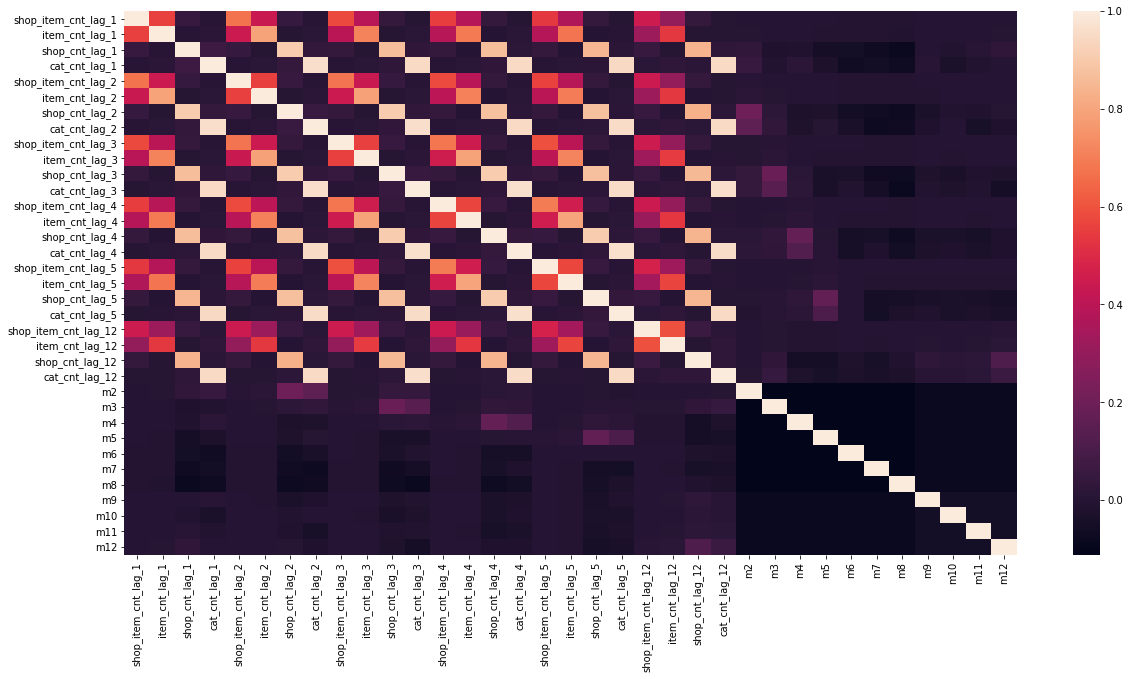

In [46]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [47]:
lm = LinearRegression()

In [48]:
# lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
# pred_lm = lm.predict(val[feats])

In [50]:
rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lm[val.shop_item_cnt>0])

18.17092825854296

In [51]:
gc.collect()

158

##### LGB

In [68]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 8min 6s


In [84]:
pred_lgb = model.predict(val[feats])
print("Val (32):",
      rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],
                y_pred = pred_lgb[val.shop_item_cnt>0] + val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag1']))

Val (32): 18.09323292066463


In [86]:
print("Val (32):",
      rmse_clip(y_true = val.loc[(val.shop_item_cnt>0) & (val.shop_item_cnt<20),'shop_item_cnt'],
                y_pred = pred_lgb[(val.shop_item_cnt>0) & (val.shop_item_cnt<20)] + val.loc[(val.shop_item_cnt>0) & (val.shop_item_cnt<20),'shop_item_cnt_lag1']))

Val (32): 2.0327460378215267


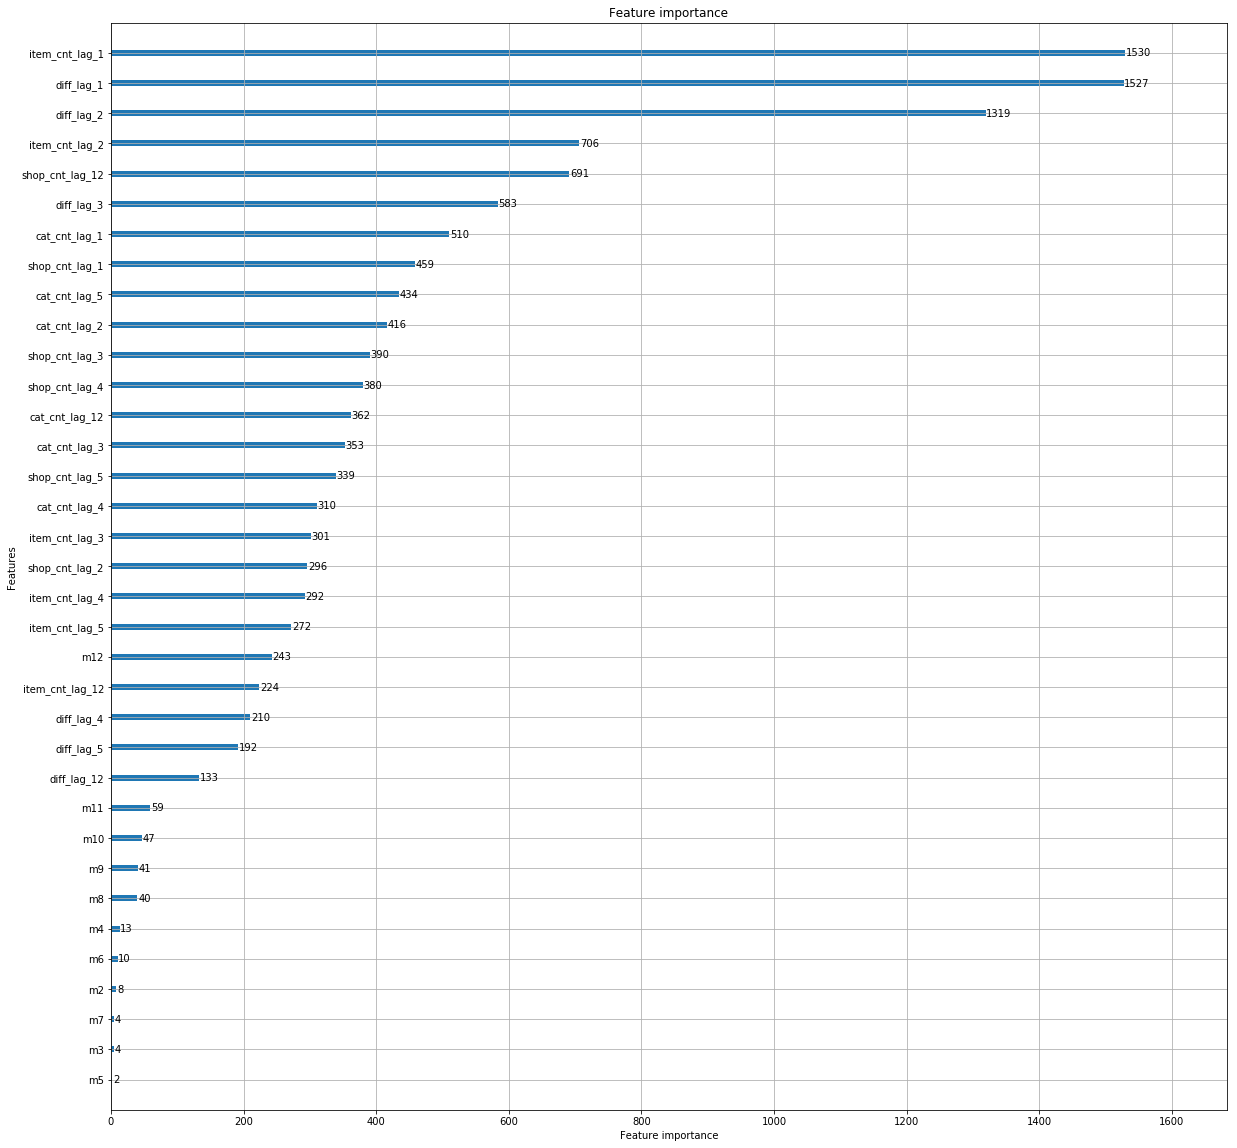

In [87]:
lgb.plot_importance(model, figsize=(20,20))

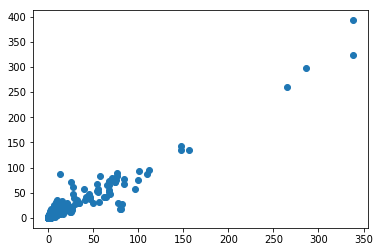

In [54]:
plt.scatter(pred_lgb[val.shop_item_cnt>0],pred_lm[val.shop_item_cnt>0])

([<matplotlib.axis.XTick at 0x221021380f0>,
 <a list of 35 Text xticklabel objects>)

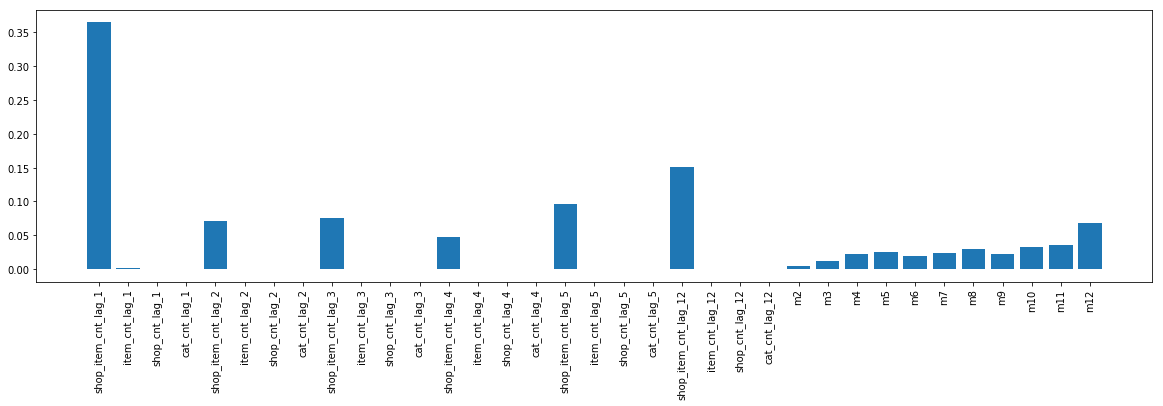

In [55]:
plt.figure(figsize=(20,5))
ticks = list(range(len(lm.coef_)))
plt.bar(ticks,height=lm.coef_)
plt.xticks(ticks,feats,rotation=90)

### Ok, why doesn't score improve???

In [57]:
val['lm_pred'] = pred_lm
val['lgb_pred'] = pred_lgb
val2 = val[val.shop_item_cnt>0]
val2.shape

(29652, 40)

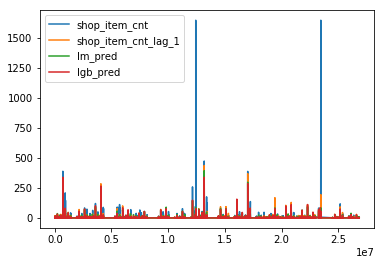

In [58]:
plt.figure(figsize=(20,5))
val2[['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

## Ok there seems to be Extremely high sales of in month 32

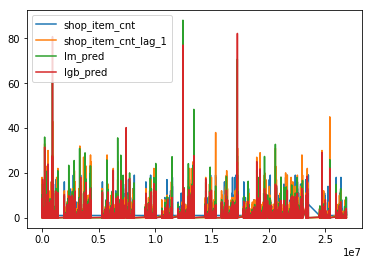

In [59]:
val2.loc[val2.shop_item_cnt<20,['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

In [60]:
for col in ['shop_item_cnt_lag_1','lm_pred','lgb_pred']:
    print(col,rmse_clip(val2.loc[val2.shop_item_cnt<20,'shop_item_cnt'],val2.loc[val2.shop_item_cnt<20,col]))

shop_item_cnt_lag_1 2.2048763591676313
lm_pred 2.061136715617056
lgb_pred 2.0084886509731676


<strong>Not too bad for the normal range... 

Stacking will work;

Since there is improvement, create a submission w only time-based features </strong>

### Create a new submission

In [5]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 6.07 s


In [6]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [11]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,diff_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,0.0,0.0,40,-6536.0,3162.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,0.0,0.0,40,-3597.0,-6536.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,0.0,0.0,40,2796.0,-3597.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
X_train = monthly_sales_all[feats]

In [15]:
y_train = monthly_sales_all['diff']

In [16]:
del monthly_sales_all
gc.collect()

207

In [18]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':3, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 9min 17s


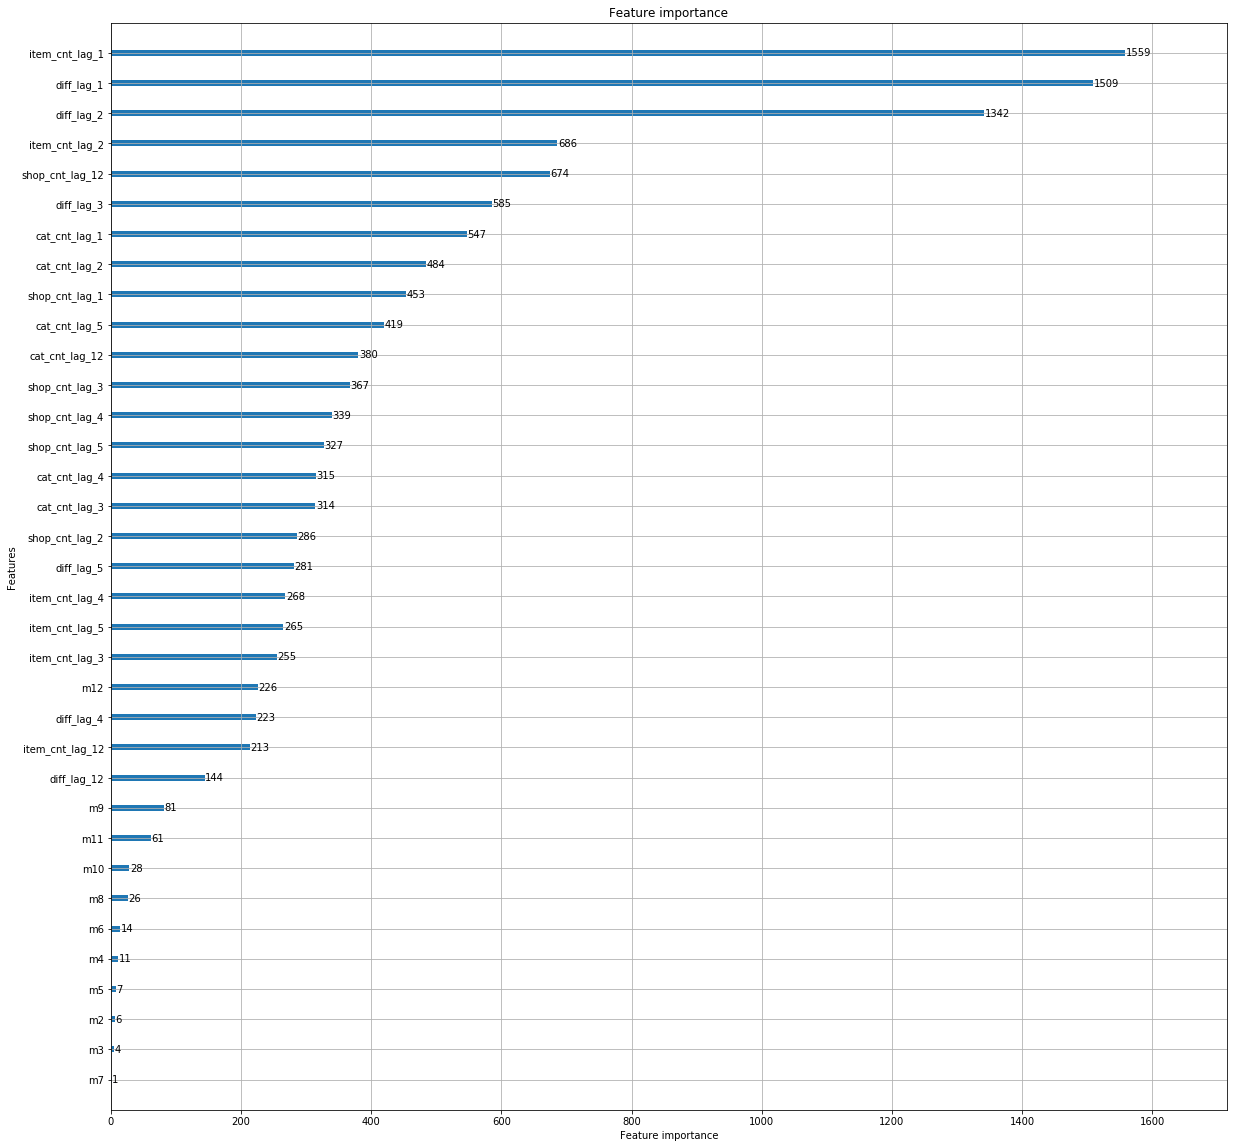

In [19]:
lgb.plot_importance(model,figsize=(20,20))

#### Read in test data and get features

In [20]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [29]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 9.49 s


In [30]:
gc.collect()

3897

In [31]:
monthly_sales_all = pd.merge(monthly_sales_all[monthly_sales_all.date_block_num==34],m_onehot_df,how='left',on='month')
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,diff_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,34,0,0,0.0,0.0,0.0,40,-7689.0,901.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,34,1,0,0.0,0.0,0.0,76,-184.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,34,2,0,0.0,0.0,0.0,40,-7689.0,901.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
test2 = pd.merge(test,monthly_sales_all,on=['shop_id','item_id'],how='left').fillna(0)
test2.loc[:,'m11'] = 1
print(test2.shape)
test2[:3]

(214200, 47)


,ID,shop_id,item_id,date_block_num,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,5,5037,34.0,0.0,-1054.0,-25.0,19.0,-2450.0,-1548.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,2,5,5233,34.0,-1.0,-1054.0,-42.0,19.0,-2450.0,-1548.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [33]:
test2['item_cnt_month'] = (model.predict(test2[feats]) + test2['shop_item_cnt_lag1']).clip(0,20)

In [34]:
test2[['ID','item_cnt_month']].to_csv(r'../output/12_1016_lgb_time_feats_on_diff.csv',index=False)